In [9]:
# Install Java and PySpark
!apt-get install openjdk-11-jdk -y
!pip install pyspark

# Set JAVA_HOME environment variable
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.28+6-1ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [10]:
# Upload your yellow_tripdata_2025-01.parquet file
from google.colab import files
uploaded = files.upload()


Saving yellow_tripdata_2025-01.parquet to yellow_tripdata_2025-01 (1).parquet


In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Start Spark session
spark = SparkSession.builder.appName("NYC Yellow Taxi Analysis").getOrCreate()

# Load the uploaded Parquet file
df = spark.read.parquet("yellow_tripdata_2025-01.parquet")
df.printSchema()
df.show(5)


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+------

[Insight-1] cleaning bounds -> distance: [0.25, 19.47] miles; fare: $4.40–$70.90.
Row count before: 3,475,226  after: 3,163,421


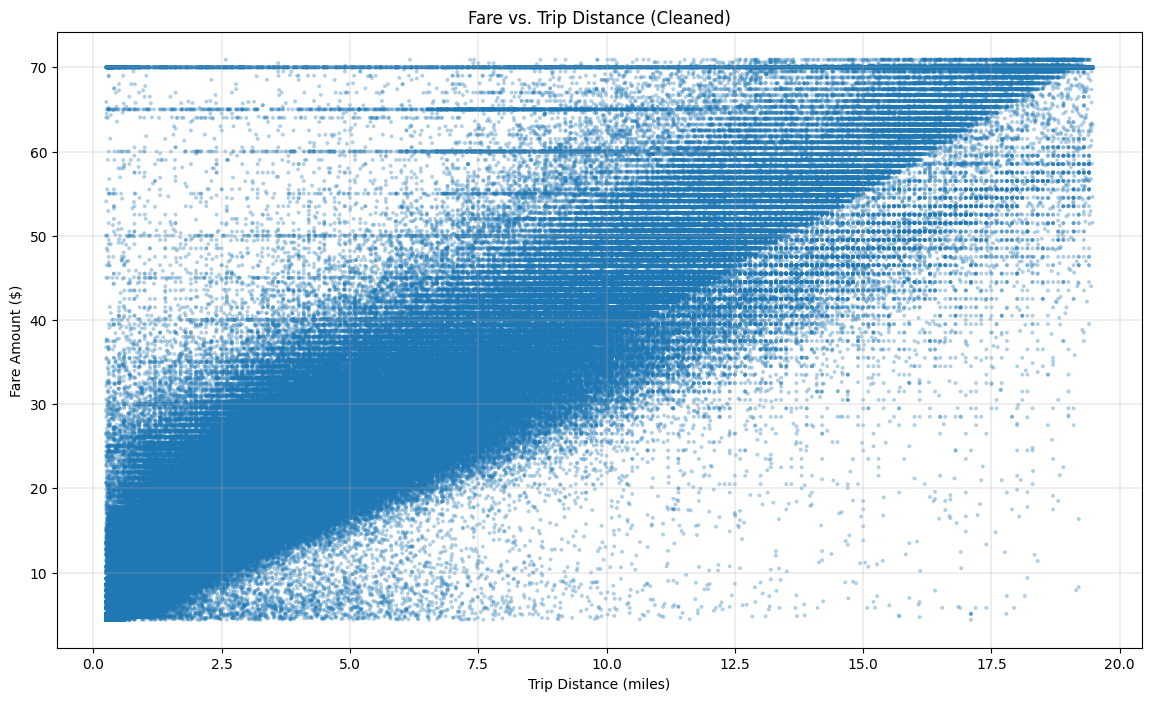

In [17]:
# === Insight 1: Fare vs Trip Distance (with robust outlier cleaning) ===
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from builtins import max as py_max, min as py_min  # ensure Python built-ins

dist_col = "trip_distance"
fare_col = "fare_amount"

# 1) Base cleaning: keep positive, non-null values
df1 = (
    df.where(F.col(dist_col).isNotNull() & F.col(fare_col).isNotNull())
      .where((F.col(dist_col) > 0) & (F.col(fare_col) > 0))
)

# 2) Quantile bounds per column
dist_p01, dist_p99 = df1.approxQuantile(dist_col, [0.01, 0.99], 0.001)
fare_p01, fare_p99 = df1.approxQuantile(fare_col, [0.01, 0.99], 0.001)

# 3) Hard sanity caps
DIST_MAX_CAP = 100.0
FARE_MAX_CAP = 300.0

# 4) Final thresholds
dist_lo = py_max(0.05, float(dist_p01))
dist_hi = py_min(DIST_MAX_CAP, float(dist_p99))
fare_lo = py_max(2.0, float(fare_p01))
fare_hi = py_min(FARE_MAX_CAP, float(fare_p99))

# 5) Apply cleaning filter
df_clean = (
    df1.where((F.col(dist_col) >= dist_lo) & (F.col(dist_col) <= dist_hi))
       .where((F.col(fare_col) >= fare_lo) & (F.col(fare_col) <= fare_hi))
)

print(f"[Insight-1] cleaning bounds -> "
      f"distance: [{dist_lo:.2f}, {dist_hi:.2f}] miles; "
      f"fare: ${fare_lo:.2f}–${fare_hi:.2f}.")
print(f"Row count before: {df.count():,}  after: {df_clean.count():,}")

# 6) Plot (CLEANED, only displayed)
pdf = df_clean.select(dist_col, fare_col).toPandas()

plt.figure(figsize=(14, 8))
plt.scatter(pdf[dist_col], pdf[fare_col], alpha=0.35, s=8, edgecolors="none")
plt.title("Fare vs. Trip Distance (Cleaned)")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.grid(True, linewidth=0.3)
plt.show()


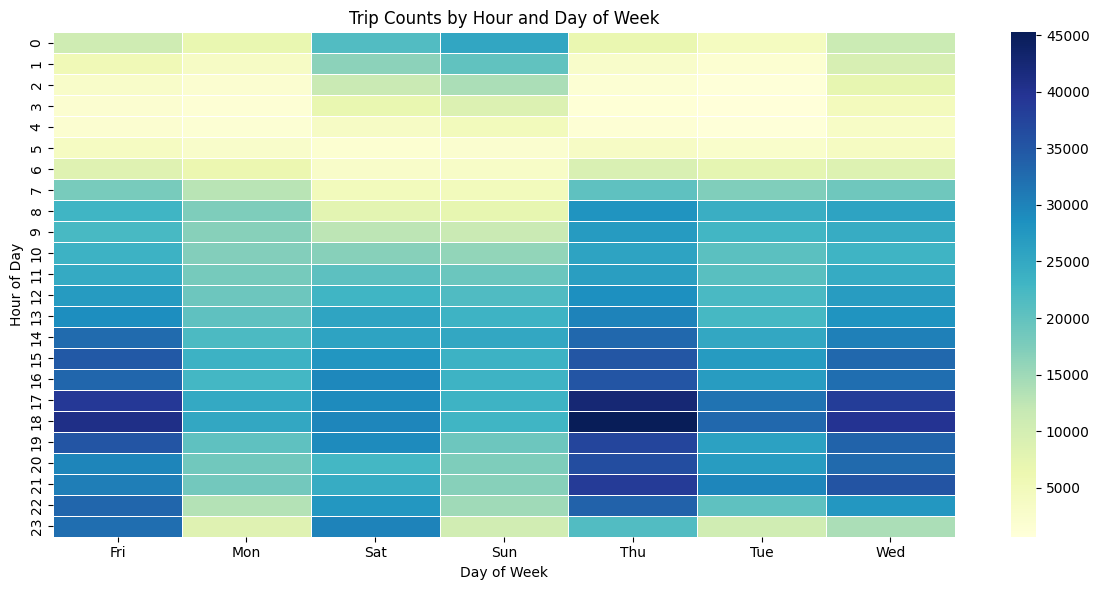

In [18]:
# Clean and enrich with hour + day
df_clean = df.filter((col("fare_amount") > 0) & (col("trip_distance") > 0))
df_time = df_clean.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
                  .withColumn("pickup_day", date_format("tpep_pickup_datetime", "E"))

# Group by hour and day
grouped = df_time.groupBy("pickup_day", "pickup_hour").count()
pivot_df = grouped.toPandas().pivot(index="pickup_hour", columns="pickup_day", values="count")

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, cmap="YlGnBu", linewidths=.5)
plt.title("Trip Counts by Hour and Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()


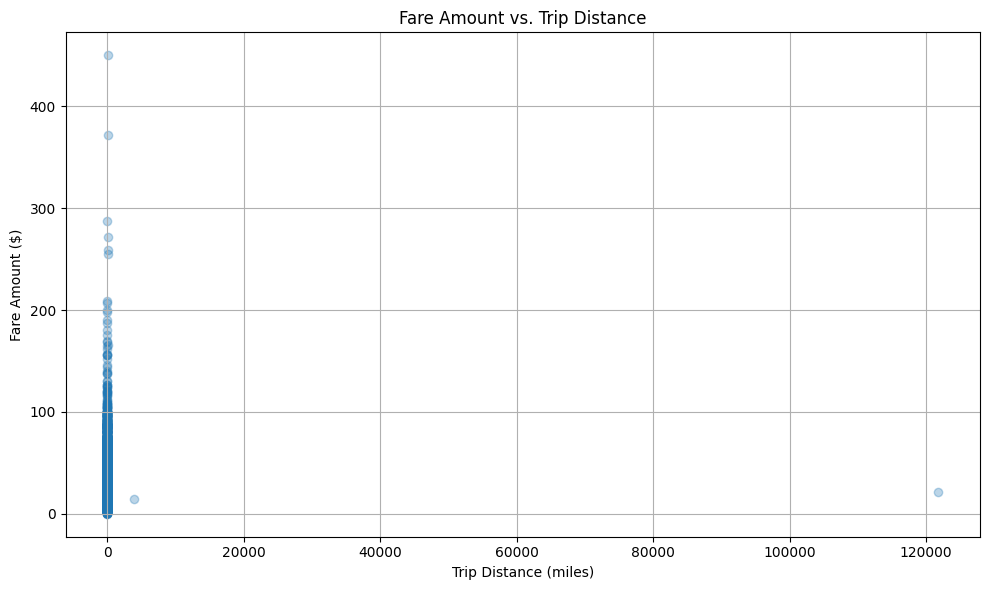

In [19]:
# Take 1% sample for better performance
fare_df = df_clean.select("fare_amount", "trip_distance").sample(False, 0.01)
fare_pd = fare_df.toPandas()

# Plot scatter
plt.figure(figsize=(10, 6))
plt.scatter(fare_pd["trip_distance"], fare_pd["fare_amount"], alpha=0.3)
plt.title("Fare Amount vs. Trip Distance")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


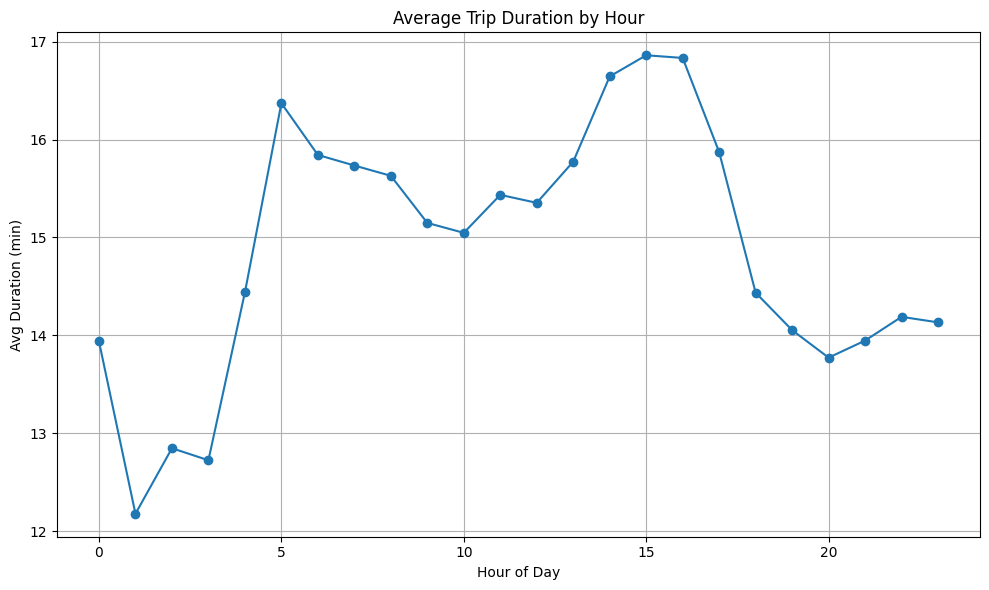

In [20]:
# Compute trip duration in minutes
trip_time_df = df_clean.withColumn("trip_duration",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60)

# Group by pickup hour
hourly_avg = trip_time_df.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
                         .groupBy("pickup_hour") \
                         .agg(avg("trip_duration").alias("avg_duration")) \
                         .orderBy("pickup_hour")

hourly_pd = hourly_avg.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(hourly_pd["pickup_hour"], hourly_pd["avg_duration"], marker='o')
plt.title("Average Trip Duration by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Avg Duration (min)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
spark.stop()
